This notebook attempts to respond to the reviewer's comment:

> How did PPIs impact the gastric lung similarity? Since the authors examined PPI use in the context of cross-pollination, it's fair to ask to see the impact of PPI use on reflux and gastric/lung microbial profiles. Does the correlation change when PPI use was controlled for in the spearman correlations? Moreover, the sub-set of patients is small, (n=31), could this also impact the correlations?

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import ranksums

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
fmeta = '../../data/clean/rosen.clinical_metadata.clean'
fjsd = '../../data/analysis/jsd.txt'

meta = pd.read_csv(fmeta, sep='\t')
meta = meta.fillna('nan')
jsd = pd.read_csv(fjsd, sep='\t')

/Users/claire/anaconda/envs/aspiration/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Remove reflux columns from metadata, because they're in the
# JSD file already
refluxcols = ['Total number of reflux episodes (acid+non-acid)',
              'number of full colum events/total events',
              'percent proximal total',
              'percent distal total']
meta = meta.drop(refluxcols, axis=1)

In [4]:
meta.head()

,sample_id,subject_id,site,mbs_consolidated,age,gender_all,abx_all,ppi_all,h2blockers_all,inhaled_steroids_all,...,foodup_all,chest_pain_all,asthma_all,chronic_cough_all,pneum_all,ear_inf_all,sinus_inf_all,pgsq_symp_all,pgsq_total_all,metadata_id
0,04-006-9B,04-006-9,bal,Aspiration/Penetration,2.969863,F,0,1,0,0,...,0,nan,1,1,nan,nan,nan,nan,nan,k23
1,04-009-2B,04-009-2,bal,Aspiration/Penetration,1.010959,M,0,0,0,0,...,0,0,1,1,1,0,0,1.12,0.61,k23
2,04-009-2G,04-009-2,gastric_fluid,Aspiration/Penetration,1.010959,M,0,0,0,0,...,0,0,1,1,1,0,0,1.12,0.61,k23
3,04-011-3B,04-011-3,bal,Normal,2.564384,F,1,1,0,0,...,0,0,0,0,1,0,0,0.29,0.26,k23
4,04-011-3G,04-011-3,gastric_fluid,Normal,2.564384,F,1,1,0,0,...,0,0,0,0,1,0,0,0.29,0.26,k23


In [5]:
# Note that JSD already excludes the samples we're not interested in
# e.g. the lung transplant and second time point samples
jsd.head()

,sample1,sample2,beta,site1,site2,site_comparison,patient_comp,subject,batch1,batch2,...,percent distal acid,percent proximal acid,percent proximal nonacid,percent distal total,number of full colum events/total events,Number of full column episodes,Was Bile CA detected?,Was Bile DCA detected?,Was Bile LCA detected?,Was Bile TCA detected?
0,01-112-7GI,01-112-7RI,0.400324,gastric_fluid,rectal_swab,gastric_fluid-rectal_swab,within,01-112-7,2016,2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01-112-7GI,01-112-7TI,0.993353,gastric_fluid,throat_swab,gastric_fluid-throat_swab,within,01-112-7,2016,2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01-112-7GI,01-164-7GI,0.994055,gastric_fluid,gastric_fluid,gastric_fluid-gastric_fluid,between,NaN,2016,2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01-112-7GI,01-164-7RI,0.575080,gastric_fluid,rectal_swab,gastric_fluid-rectal_swab,between,NaN,2016,2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01-112-7GI,01-164-7TI,0.995439,gastric_fluid,throat_swab,gastric_fluid-throat_swab,between,NaN,2016,2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Prepare within-person gastric-lung data

In [6]:
lunggastric = jsd.query('patient_comp == "within"').query('site_comparison == "bal-gastric_fluid"')
print(lunggastric.shape)

(88, 39)


In [7]:
# Drop 'site' to remove duplicate rows
# Drop 'mbs_consolidated' bc it's already in lunggastric
lunggastric = pd.merge(lunggastric, 
                       meta.drop(['site', 'mbs_consolidated'], axis=1).drop_duplicates(), 
                       left_on='subject', right_on='subject_id', how='left')
lunggastric.head()

,sample1,sample2,beta,site1,site2,site_comparison,patient_comp,subject,batch1,batch2,...,foodup_all,chest_pain_all,asthma_all,chronic_cough_all,pneum_all,ear_inf_all,sinus_inf_all,pgsq_symp_all,pgsq_total_all,metadata_id
0,02-098-5B,02-098-5G,0.243337,bal,gastric_fluid,bal-gastric_fluid,within,02-098-5,2014,2014,...,1,0,1,1,0,0,0,0.12,0.48,k23
1,02-098-5B,02-098-5G,0.243337,bal,gastric_fluid,bal-gastric_fluid,within,02-098-5,2014,2014,...,1,0,1,1,0,0,0,0.12,0.48,k23
2,02-098-5B,02-098-5G,0.243337,bal,gastric_fluid,bal-gastric_fluid,within,02-098-5,2014,2014,...,1,0,1,1,0,0,0,0.12,0.48,k23
3,02-099-7B,02-099-7G,0.286062,bal,gastric_fluid,bal-gastric_fluid,within,02-099-7,2014,2014,...,1,0,1,1,0,0,0,0.82,0.61,k23
4,02-099-7B,02-099-7G,0.286062,bal,gastric_fluid,bal-gastric_fluid,within,02-099-7,2014,2014,...,1,0,1,1,0,0,0,0.82,0.61,k23


In [8]:
## Metadata column edits

# Clean up the reflux cols
lunggastric[refluxcols] = lunggastric[refluxcols].replace('n/a', np.nan)
lunggastric[refluxcols] = lunggastric[refluxcols].astype(float)

# Some missing entries are wrongly entered as 1
lunggastric['number of full colum events/total events'] = lunggastric['number of full colum events/total events'].replace(1, np.nan)

keepcols = ['sample1', 'sample2', 'beta', 'site1', 'site2', 'site_comparison',
            'patient_comp', 'subject', 'batch1', 'batch2', 'mbs_consolidated',
            'ppi_all'] + refluxcols

lunggastric = lunggastric[keepcols].drop_duplicates()
lunggastric.shape

(88, 16)

/Users/claire/anaconda/envs/aspiration/lib/python2.7/site-packages/seaborn/categorical.py:2775: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


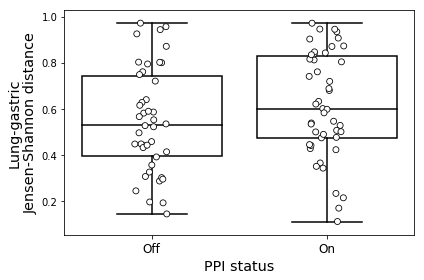

In [9]:
fig, ax = plt.subplots()

boxprops = {'edgecolor': 'k', 'facecolor': 'w'}
lineprops = {'color': 'k'}

boxplot_kwargs = {'boxprops': boxprops, 'medianprops': lineprops,
                   'whiskerprops': lineprops, 'capprops': lineprops}


sns.boxplot(data=lunggastric, x='ppi_all', y='beta',
            fliersize=0, ax=ax, color='w',
            **boxplot_kwargs)
sns.stripplot(data=lunggastric, x='ppi_all', y='beta',
              jitter=True, split=True,
              linewidth=0.8, edgecolor='k', s=6, color='w')

ax.set_xticklabels(['Off', 'On', 'Unknown'], fontsize='large')
ax.set_xlabel('PPI status', fontsize='x-large')
ax.set_ylabel('Lung-gastric\nJensen-Shannon distance', fontsize='x-large')

fig.tight_layout()

fig.savefig('../../final/figures/reviewer.ppi_vs_lung_gastric.png', dpi=200)

In [10]:
x = lunggastric.query('ppi_all == "0"')['beta'].values
y = lunggastric.query('ppi_all == "1"')['beta'].values
ranksums(x, y)

RanksumsResult(statistic=-1.4870037404874281, pvalue=0.13701382303597215)

In [11]:
# Number on/off PPI
lunggastric.groupby(['ppi_all']).size()

ppi_all
0    42
1    46
dtype: int64

In [12]:
lunggastric['subject'].unique().shape

(88,)

In [13]:
lunggastric.columns#.query('subject == "02-098-5"')#.to_csv('tmp.csv')

Index([u'sample1', u'sample2', u'beta', u'site1', u'site2', u'site_comparison',
       u'patient_comp', u'subject', u'batch1', u'batch2', u'mbs_consolidated',
       u'ppi_all', u'Total number of reflux episodes (acid+non-acid)',
       u'number of full colum events/total events', u'percent proximal total',
       u'percent distal total'],
      dtype='object')

In [14]:
# Number on/off, who also have reflux metadata
lunggastric.dropna(subset=refluxcols).groupby(['ppi_all']).size()

ppi_all
0    17
1    11
dtype: int64

# PPI usage vs. reflux correlation

In [15]:
# Prepare data for plotting as in 2018-01-23 notebook

# And replace nan's with "nan" strings for aspiration status
lunggastric['mbs_consolidated'] = lunggastric['mbs_consolidated'].fillna('Not tested')

In [16]:
# Multiple the percent columns by 100 to get into values of percentage
lunggastric['percent proximal total'] = 100*lunggastric['percent proximal total']
lunggastric['percent distal total'] = 100*lunggastric['percent distal total']

In [17]:
asp_colors = {'Normal': '#B25116', 'Aspiration/Penetration': '#FB84D1', 'Not tested': '#C9C9C9'}
hue_order = ['Normal', 'Aspiration/Penetration', 'Not tested']

idvars = ['sample1', 'sample2', 'beta', 'site1', 'site2', 
          'site_comparison', 'patient_comp', 'subject', 
          'batch1', 'batch2', 'mbs_consolidated', 'ppi_all']

tidylunggastric = pd.melt(lunggastric, value_vars=refluxcols, 
                  var_name='reflux_type', value_name='reflux_value',
                  id_vars=idvars)
tidylunggastric['ppi_all'] = tidylunggastric['ppi_all'].fillna('nan')
toplot = tidylunggastric

# And drop any samples without the reflux actually measured
toplot = toplot.dropna(subset=['beta', 'reflux_value'])

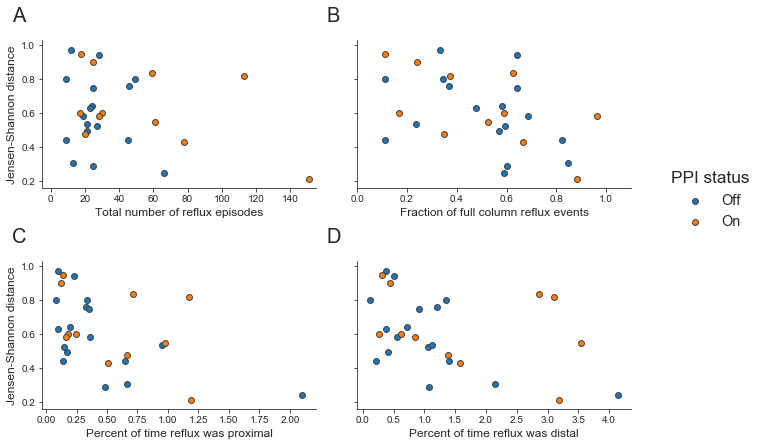

In [18]:
sns.set_style('ticks')
g = sns.FacetGrid(
    data=toplot, 
    col='reflux_type', col_wrap=2, 
    hue='ppi_all', 
    sharex=False, legend_out=True, 
    aspect=1.5)

scatter_kwargs = {'s' : 35, 'edgecolors': '0.25'}
g.map(plt.scatter, 'reflux_value', 'beta', **scatter_kwargs).set_titles("{col_name}")

# Axes limits
g.facet_axis(0, 0).set_xlim([-5, 155])
g.facet_axis(0, 1).set_xlim([0, 1.1])
#g.facet_axis(0, 2).set_xlim([-0.002, 0.024])
#g.facet_axis(0, 3).set_xlim([-0.002, 0.049])

# X and Y axis labels
g.facet_axis(0, 0).set_ylabel('Jensen-Shannon distance', fontsize='large')
g.facet_axis(0, 2).set_ylabel('Jensen-Shannon distance', fontsize='large')

g.facet_axis(0, 2).set_xlabel('')
g.facet_axis(0, 3).set_xlabel('')

# Legend, anchored to top right axis
lgd = g.facet_axis(0, 1)\
    .legend(bbox_to_anchor=(1.1, 0.2), 
            labels=['Off', 'On', 'Unknown'],
            loc='upper left', fontsize='x-large',
            frameon=False)
lgd.set_title('PPI status', prop={'size': 'xx-large'})

# Remove titles
g.set_titles('')
#g.facet_axis(0, 1).set_xlabel('Percentage of full column reflux events', **title_kwargs)
#g.facet_axis(0, 2).set_xlabel('Percent of time reflux was proximal', **title_kwargs)
#g.facet_axis(0, 3).set_xlabel('Percent of time reflux was distal', **title_kwargs)

# X-labels
title_kwargs = {'fontsize': 'large'}
g.facet_axis(0, 0).set_xlabel('Total number of reflux episodes', **title_kwargs)
g.facet_axis(0, 1).set_xlabel('Fraction of full column reflux events', **title_kwargs)
g.facet_axis(0, 2).set_xlabel('Percent of time reflux was proximal', **title_kwargs)
g.facet_axis(0, 3).set_xlabel('Percent of time reflux was distal', **title_kwargs)

# A, B, C, D labels
lbls = ['A', 'B', 'C', 'D']
for i in [0, 1, 2, 3]:
    a = g.facet_axis(0, i)
    a.text(-0.11, 1.125, lbls[i], transform=a.transAxes, fontsize=20)
#txt = ax.text(-0.11, 1.025, 'A', transform=ax.transAxes, fontsize=24)

plt.subplots_adjust(hspace=0.5, wspace=0.15)

plt.savefig('../../final/figures/reviewer.reflux_correlations_ppi_status.png', 
           bbox_inches='tight', #bbox_extra_artists=(lgd),
           dpi=200)